In [1]:
import re
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from gears import PertData
import sys
sys.path.insert(0, "../")
from scgpt.utils import compute_perturbation_metrics

/home/users/geroldcsendes/miniconda3/envs/scgpt_yml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def parse_training_log(log_path):
    """
    Parses a training log file and extracts batch losses and validation metrics.

    Args:
        log_path (str): Path to the log file.

    Returns:
        df_losses (pd.DataFrame): DataFrame with columns ['epoch', 'batch', 'loss']
        df_val_metrics (pd.DataFrame): DataFrame with validation metrics per epoch
    """
    # Regular expressions
    train_pattern = re.compile(r'epoch\s+(\d+)\s+\|\s+(\d+)/\d+\s+batches.*?loss\s+([\d.]+)')
    val_pattern = re.compile(r'val_metrics at epoch (\d+):')
    metrics_pattern = re.compile(r'\{(.+?)\}')
    
    # Storage
    batch_losses = []
    val_metrics = {}

    with open(log_path, "r") as file:
        lines = file.readlines()

    current_epoch = None

    for line in lines:
        # Match batch loss
        train_match = train_pattern.search(line)
        if train_match:
            epoch, batch, loss = int(train_match.group(1)), int(train_match.group(2)), float(train_match.group(3))
            batch_losses.append((epoch, batch, loss))
            continue

        # Match validation start
        val_match = val_pattern.search(line)
        if val_match:
            current_epoch = int(val_match.group(1))
            continue
        
        # Match validation metrics
        metrics_match = metrics_pattern.search(line)
        if metrics_match and current_epoch:
            metrics_str = metrics_match.group(1)
            metrics_dict = {k.strip("' "): float(v) for k, v in 
                            (item.split(": ") for item in metrics_str.split(", "))}
            val_metrics[current_epoch] = metrics_dict

    # Convert batch losses to DataFrame
    df_losses = pd.DataFrame(batch_losses, columns=["epoch", "batch", "loss"])

    # Convert validation metrics to DataFrame
    df_val_metrics = pd.DataFrame.from_dict(val_metrics, orient="index").reset_index()
    df_val_metrics.rename(columns={"index": "epoch"}, inplace=True)

    df_losses["batch"] = np.linspace(100, 100*len(df_losses), len(df_losses))
    df_losses["batch"] = df_losses["batch"].astype(int)

    return df_losses, df_val_metrics

def plot_loss_delta(loss, metrics, dataset, model, out_dir = Path("../figures/models/training")):

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    sns.lineplot(data=loss, x="batch", y="loss", ax=axs[0])
    axs[0].set_title(f"Training loss for {dataset} {model}")

    sns.lineplot(data=metrics, x="epoch", y="pearson_delta", ax=axs[1])
    axs[1].set_title(f"Validation pearson delta for {dataset} {model}")

    plt.savefig(out_dir / f"{dataset}_{model}_training.png")

    plt.show()

def parse_training_log_foundation(log_file_path):
    """
    Parse training log file to extract epoch and train loss values with detailed debugging.
    """
    # Read the entire file content
    with open(log_file_path, 'r') as file:
        log_content = file.read()
    
    # Print first few lines for inspection
    # print("First 500 characters of log file:")
    # print(log_content[:500])
    
    # Try multiple regex patterns
    patterns = [
        r'Epoch (\d+) \| Step (\d+) / (\d+) \| Train Loss: (\d+\.\d+)',  # Original pattern
        r'Epoch (\d+) \| Step (\d+) / \d+ \| Train Loss: (\d+\.\d+)',    # Removed third capture group
        r'Epoch (\d+).*Train Loss: (\d+\.\d+)'                            # Very permissive pattern
    ]
    
    for pattern in patterns:
        matches = re.findall(pattern, log_content)
        # print(f"\nTesting pattern: {pattern}")
        # print(f"Total matches found: {len(matches)}")
        
        if matches:
            # print("First few matches:")
            for match in matches[:5]:
                pass
                #print(match)
            
            # Create DataFrame based on the successful pattern
            if len(matches[0]) == 4:  # Full match with step
                df = pd.DataFrame(matches, columns=['Epoch', 'Step', 'Total Steps', 'loss'])
                df['Epoch'] = pd.to_numeric(df['Epoch'])
                df['loss'] = pd.to_numeric(df['loss'])
            elif len(matches[0]) == 3:  # Match with step
                df = pd.DataFrame(matches, columns=['Epoch', 'Step', 'loss'])
                df['Epoch'] = pd.to_numeric(df['Epoch'])
                df['loss'] = pd.to_numeric(df['loss'])
            else:  # Simple match
                df = pd.DataFrame(matches, columns=['Epoch', 'loss'])
                df['Epoch'] = pd.to_numeric(df['Epoch'])
                df['loss'] = pd.to_numeric(df['loss'])
            
            df["batch"] = np.linspace(1, 50 * len(df) + 1, len(df))
            df["batch"] = df["batch"].astype(int)

            return df
    
    print("No matching patterns found!")
    return pd.DataFrame()

def get_val_metrics_foundation(dir, pert_data):

    res_list = []
    for i in range(10):
        res_val = np.load(dir / f"val_res_e{i}.npz")
        res_val = {k: v for k, v in res_val.items()}
        val_metrics = compute_perturbation_metrics(
            res_val, pert_data.adata[pert_data.adata.obs["condition"] == "ctrl"]
        )
        res_list.append(val_metrics)
    res_df = pd.DataFrame(res_list)
    res_df["epoch"] = np.arange(10)
    return res_df


## scGPT

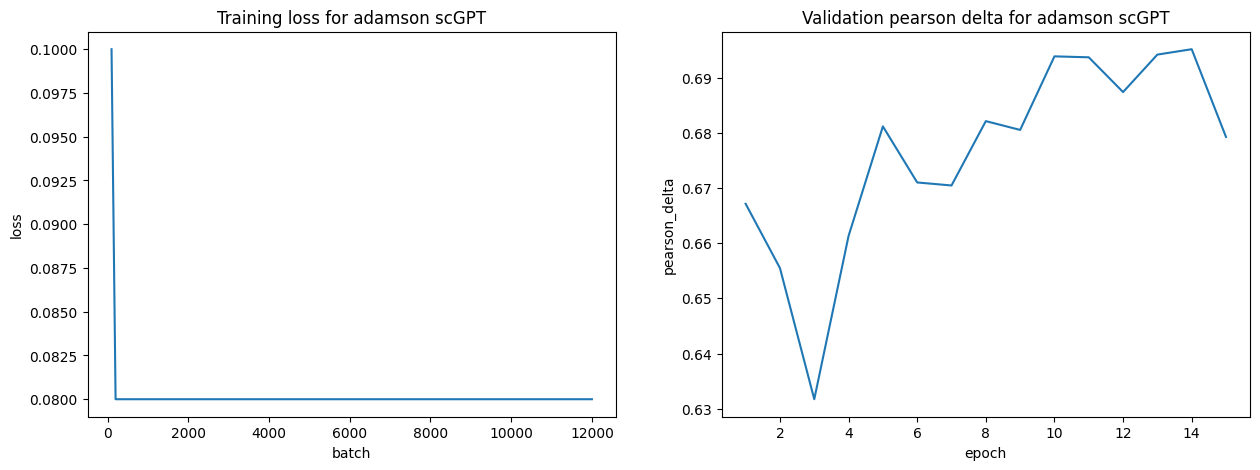

In [3]:
amdamson_log_file = "./save/arch/dev_perturb_adamson-Feb28-07-50/run.log"
adamson_scgpt_losses, adamson_scgpt_val_metrics = parse_training_log(amdamson_log_file)

plot_loss_delta(adamson_scgpt_losses, adamson_scgpt_val_metrics, "adamson", "scGPT")

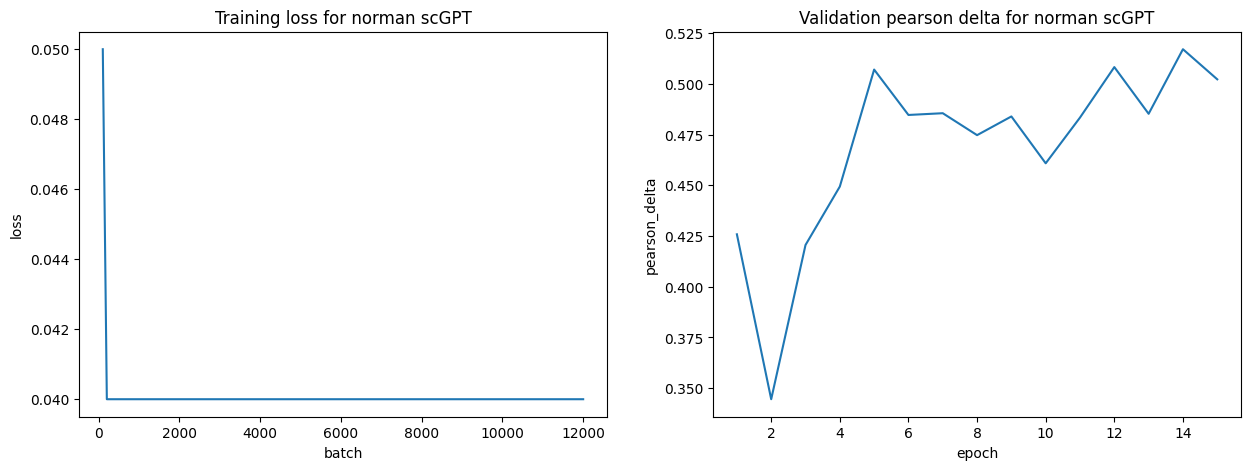

In [4]:
norman_log_file = "./save/dev_perturb_norman-Sep24-13-29/run.log"
norman_scgpt_losses, norman_scgpt_val_metrics = parse_training_log(norman_log_file)

plot_loss_delta(norman_scgpt_losses, norman_scgpt_val_metrics, "norman", "scGPT")

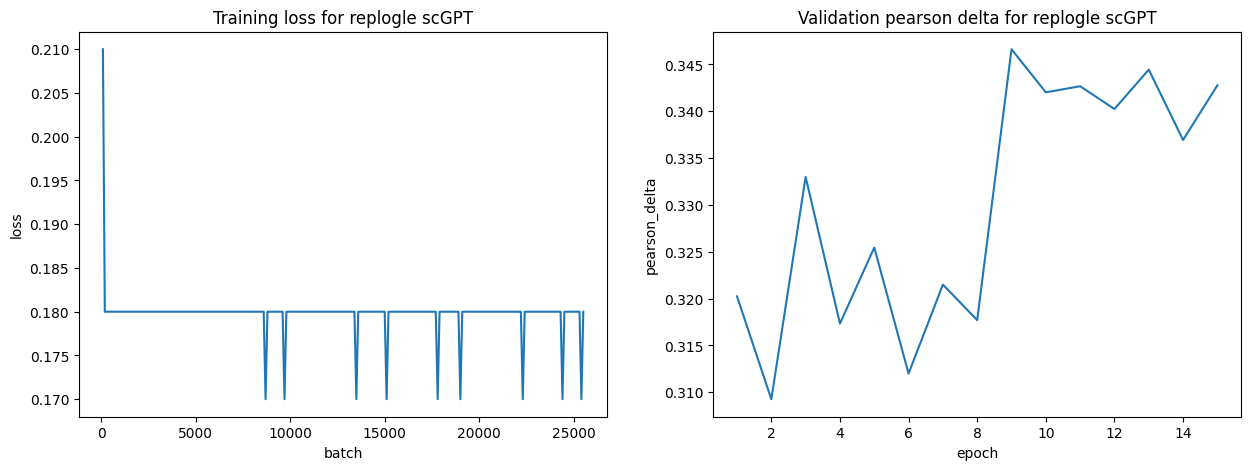

In [5]:
replogle_log_file = "./save/dev_perturb_replogle-Sep24-15-06/run.log"
replogle_scgpt_losses, replogle_scgpt_val_metrics = parse_training_log(replogle_log_file)

plot_loss_delta(replogle_scgpt_losses, replogle_scgpt_val_metrics, "replogle", "scGPT")

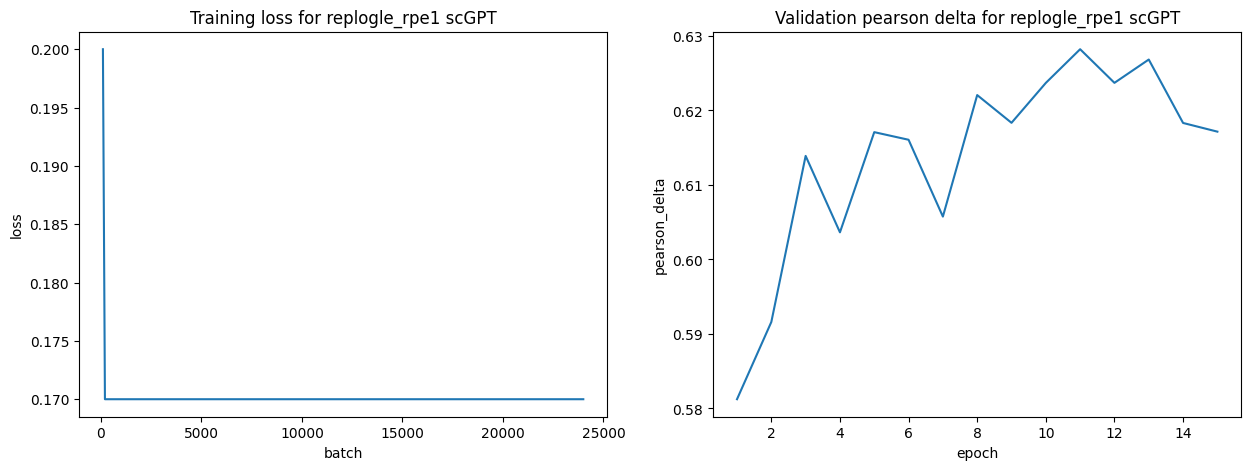

In [6]:
replogle_rpe1_log_file = "./save/dev_perturb_replogle_rpe1-Mar05-11-54/run.log"
replogle_rpe1_scgpt_losses, replogle_rpe1_scgpt_val_metrics = parse_training_log(replogle_rpe1_log_file)

plot_loss_delta(replogle_rpe1_scgpt_losses, replogle_rpe1_scgpt_val_metrics, "replogle_rpe1", "scGPT")

## scFoundation

In [7]:
sc_foundation_base = Path("../scFoundation/GEARS/results/")

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:22
Done!


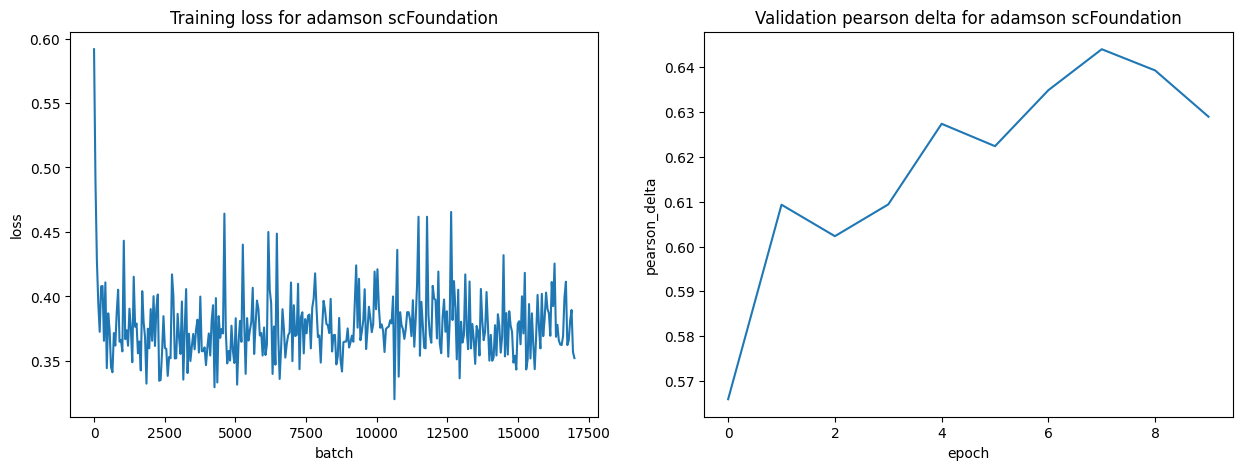

In [8]:
adamson_found_dir = sc_foundation_base / "adamson/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_32_accmu_1_mode_v1_highres_0_lr_0.0005/2025-02-12_10-47-01"
adamson_found_log = adamson_found_dir / "train.log"

adamson_found_losses = parse_training_log_foundation(adamson_found_log)

pert_data_adamson_sc = PertData("../scFoundation/GEARS/data")
pert_data_adamson_sc.load(data_name='adamson')
pert_data_adamson_sc.prepare_split(split="simulation", seed=1)

adamson_found_val_metrics = get_val_metrics_foundation(adamson_found_dir, pert_data_adamson_sc)

plot_loss_delta(adamson_found_losses, adamson_found_val_metrics, "adamson", "scFoundation")

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:43
combo_seen2:19
unseen_single:36
Done!


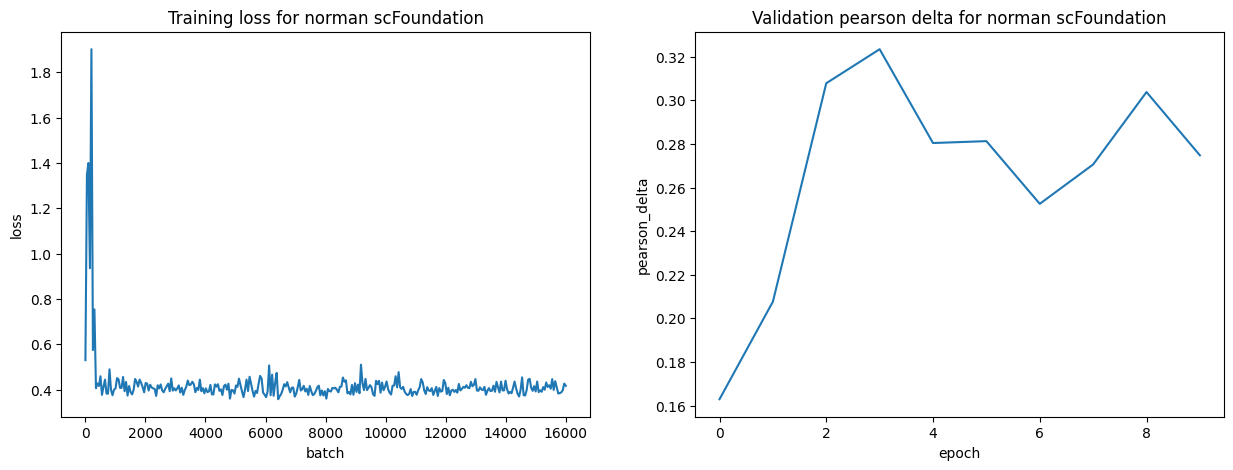

In [9]:
norman_found_dir = sc_foundation_base / "norman/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_32_accmu_1_mode_v1_highres_0_lr_0.01/2025-02-12_00-47-27"
norman_found_log = norman_found_dir / "train.log"

norman_found_losses = parse_training_log_foundation(norman_found_log)

pert_data_norman = PertData("../scFoundation/GEARS/data")
pert_data_norman.load(data_name='norman')
pert_data_norman.prepare_split(split="simulation", seed=1)

norman_found_val_metrics = get_val_metrics_foundation(norman_found_dir, pert_data_norman)

plot_loss_delta(norman_found_losses, norman_found_val_metrics, "norman", "scFoundation")

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:43
combo_seen2:19
unseen_single:36
Done!


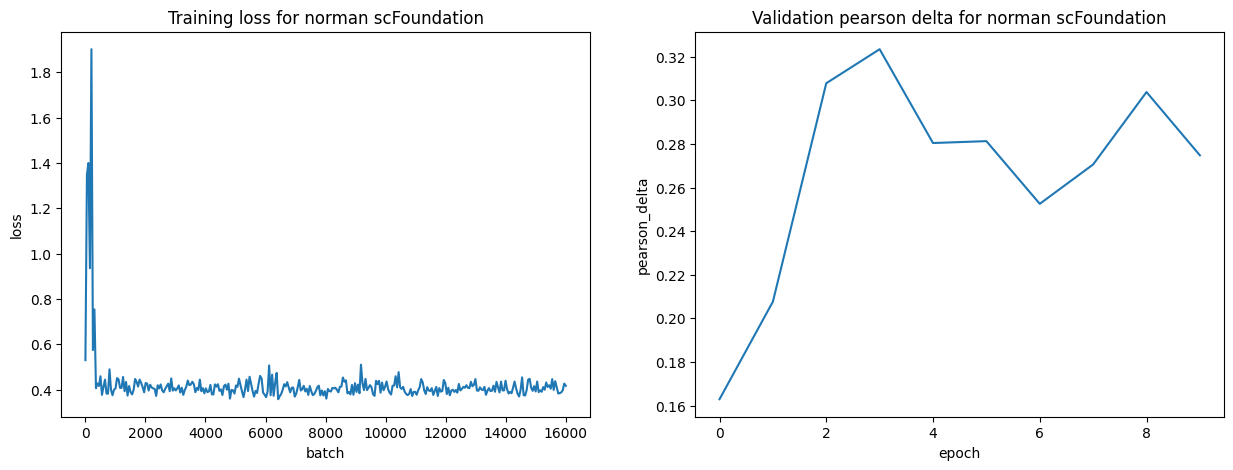

In [10]:
pert_data_norman = PertData("../scFoundation/GEARS/data")
pert_data_norman.load(data_name='norman')
pert_data_norman.prepare_split(split="simulation", seed=1)

norman_found_val_metrics = get_val_metrics_foundation(norman_found_dir, pert_data_norman)

plot_loss_delta(norman_found_losses, norman_found_val_metrics, "norman", "scFoundation")

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:272
Done!


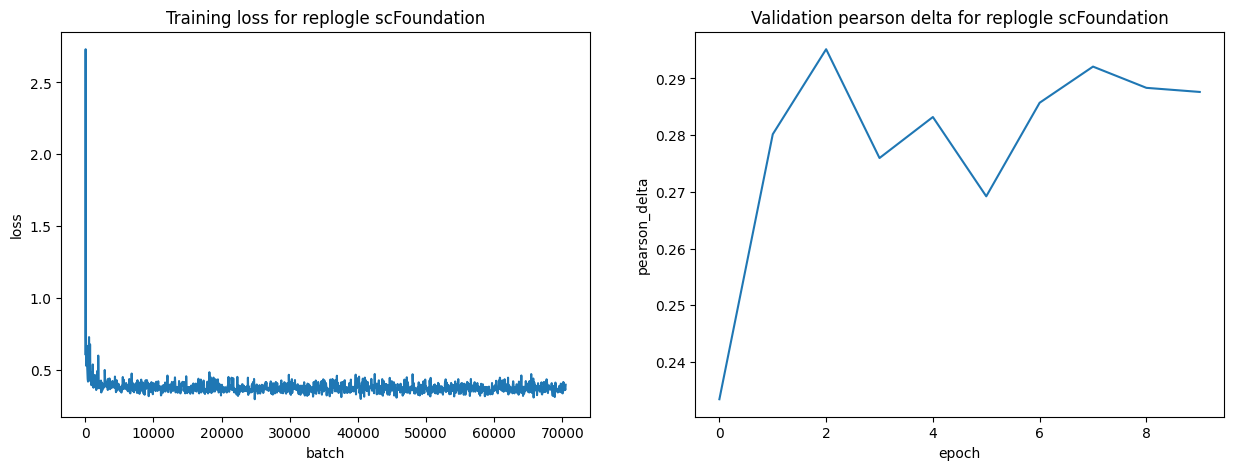

In [11]:
replogle_found_dir = sc_foundation_base / "replogle_k562_essential/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_16_accmu_2_mode_v1_highres_0_lr_0.01/2025-02-17_16-45-12"
replogle_found_log = replogle_found_dir / "train.log"

replogle_found_losses = parse_training_log_foundation(replogle_found_log)

pert_data_replogle = PertData("../scFoundation/GEARS/data")
pert_data_replogle.load(data_path="../scFoundation/GEARS/data/replogle_k562_essential")
pert_data_replogle.prepare_split(split="simulation", seed=1)

replogle_found_val_metrics = get_val_metrics_foundation(replogle_found_dir, pert_data_replogle)

plot_loss_delta(replogle_found_losses, replogle_found_val_metrics, "replogle", "scFoundation")

Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:384
Done!


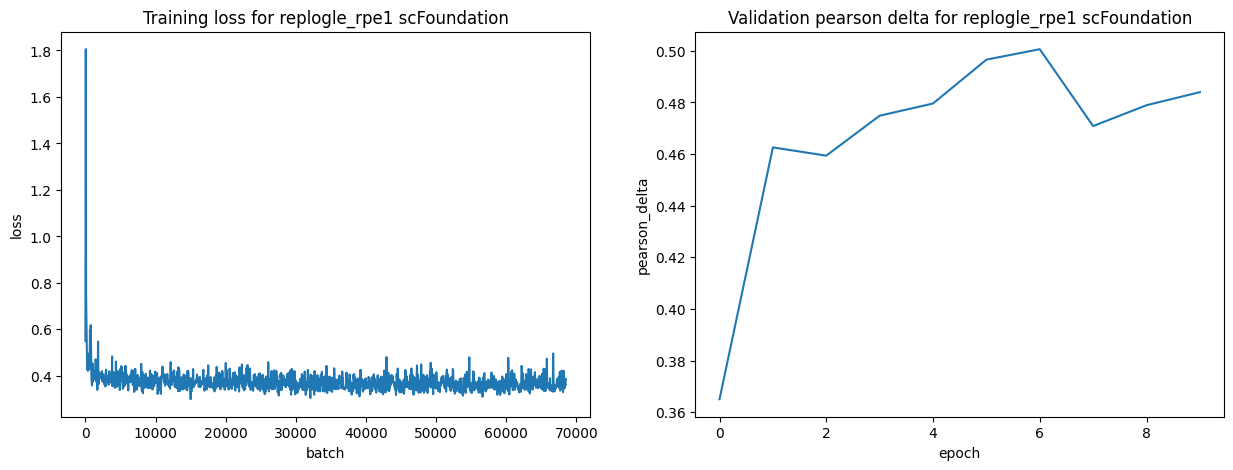

In [12]:
replogle_rpe1_found_dir = sc_foundation_base / "replogle_rpe1_essential_raw/0.75/baseline_simulation_seed_1_hidden_512_epochs_10_batch_16_accmu_2_mode_v1_highres_0_lr_0.01/2025-02-26_07-59-12"
replogle_rpe1_found_log = replogle_rpe1_found_dir / "train.log"

replogle_rpe1_found_losses = parse_training_log_foundation(replogle_rpe1_found_log)

pert_data_replogle_rpe1 = PertData("../scFoundation/GEARS/data")
pert_data_replogle_rpe1.load(data_path="../scFoundation/GEARS/data/replogle_rpe1_essential_raw")
pert_data_replogle_rpe1.prepare_split(split="simulation", seed=1)

replogle_rpe1_found_val_metrics = get_val_metrics_foundation(replogle_rpe1_found_dir, pert_data_replogle_rpe1)

plot_loss_delta(replogle_rpe1_found_losses, replogle_rpe1_found_val_metrics, "replogle_rpe1", "scFoundation")

## Write files

In [ ]:
# scgpt
OUT_DIR = Path("../figures/models/training")

adamson_scgpt_losses.to_csv(OUT_DIR / "adamson_scgpt_losses.csv", index=False)
adamson_scgpt_val_metrics.to_csv(OUT_DIR / "adamson_scgpt_val_metrics.csv", index=False)

norman_scgpt_losses.to_csv(OUT_DIR / "norman_scgpt_losses.csv", index=False)
norman_scgpt_val_metrics.to_csv(OUT_DIR / "norman_scgpt_val_metrics.csv", index=False)

replogle_scgpt_losses.to_csv(OUT_DIR / "replogle_scgpt_losses.csv", index=False)
replogle_scgpt_val_metrics.to_csv(OUT_DIR / "replogle_scgpt_val_metrics.csv", index=False)

replogle_rpe1_scgpt_losses.to_csv(OUT_DIR / "replogle_rpe1_scgpt_losses.csv", index=False)
replogle_rpe1_scgpt_val_metrics.to_csv(OUT_DIR / "replogle_rpe1_scgpt_val_metrics.csv", index=False)

In [ ]:
# scFoundation
adamson_found_losses.to_csv(OUT_DIR / "adamson_scfoundation_losses.csv", index=False)
adamson_found_val_metrics.to_csv(OUT_DIR / "adamson_scfoundation_val_metrics.csv", index=False)

norman_found_losses.to_csv(OUT_DIR / "norman_scfoundation_losses.csv", index=False)
norman_found_val_metrics.to_csv(OUT_DIR / "norman_scfoundation_val_metrics.csv", index=False)

replogle_found_losses.to_csv(OUT_DIR / "replogle_scfoundation_losses.csv", index=False)
replogle_found_val_metrics.to_csv(OUT_DIR / "replogle_scfoundation_val_metrics.csv", index=False)

replogle_rpe1_found_losses.to_csv(OUT_DIR / "replogle_rpe1_scfoundation_losses.csv", index=False)
replogle_rpe1_found_val_metrics.to_csv(OUT_DIR / "replogle_rpe1_scfoundation_val_metrics.csv", index=False)